In [16]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath
import tensorflow as tf 

#MlFlow
import mlflow
from mlflow import log_metric, log_param


from itertools import product

import time

#  Preprocesamiento de datos

## Modelo numérico

In [3]:
def lee_u(u_file):
    values = []
    times = []
    fd = open(u_file,'r')
    for tupla in fd.read().split('\n\n'):
        if tupla != '':
            tiempo, datos = tupla.split('\n')
            times.append(float(tiempo))
            vector = []
            for value in datos.split('\t'):
                    if value != '':
                        vector.append(float(value))
            values.append(vector)
    values = np.array(values)
    fd.close()
    return times, values

def lee_mesh(mesh_file):
    fd = open(mesh_file)
    for batch in fd.read().split('\n\n'):
        if batch[0:8]=='Vertices':
            vertices = batch
    fd.close()
    coordenadas = []

    for vertice in vertices.split('\n'):
        if len(vertice.split(' ')) == 5:
            coordenadas.append([float(vertice.split(' ')[0]),float(vertice.split(' ')[1]),float(vertice.split(' ')[2])])
    coordenadas = np.array(coordenadas)
    return coordenadas

def preparadatos(u_file,mesh_file):
    datos = lee_u(u_file)
    mesh = lee_mesh(mesh_file)
    
    sec = datos[0][0]
    fullmesh = np.insert(mesh,3,sec,axis=1)
    
    for i in range(1,len(datos[0])):
        sec = datos[0][i]
        fullmesh = np.append(fullmesh,np.insert(mesh,3,sec,axis=1),axis=0)
    
    valores = datos[1].flatten()
    
    return fullmesh,valores

from scipy.interpolate import griddata

## Mallado del test (estático)



In [49]:
#Genero los puntos radiales


denspt = 5 # Densidad de puntos de evaluación de los funcionales
#Genero los puntos radiales

rr = np.linspace(0,1, np.rint(denspt).astype(int))**0.75
ff = np.linspace(0,2*np.pi,np.rint(2*np.pi*denspt).astype(int))
pp = np.linspace(0,np.pi,np.rint(np.pi*denspt).astype(int))
tt = np.linspace(0,5,np.rint(5*denspt).astype(int))

grid = np.meshgrid(rr,ff,pp,tt)

rad, fi, psi, tt_r = grid

xx_r = rad*np.cos(fi) * np.sin(psi)
yy_r = rad*np.sin(fi) * np.cos(psi)
zz_r = rad*np.cos(psi)
tt_r = tt_r

xx_r, yy_r, zz_r, tt_r = xx_r.flatten(), yy_r.flatten(), zz_r.flatten(), tt_r.flatten()

puntos_rad = np.stack((xx_r,yy_r,zz_r,tt_r),axis=1)

#Genero los puntos cartesianos
# Densidad de puntos de evaluación de los funcionales
xmin,xmax=-2,2 # Límites en x
ymin,ymax =-2,2 # Límites en y
zmin,zmax = -2,2 # Límites en z
tmin,tmax=0,5 # Límites en tiempo t
xrange=xmax-xmin
yrange=ymax-ymin
zrange=zmax-zmin
trange=tmax-tmin

xx = np.linspace(xmin, xmax, np.rint(xrange*denspt).astype(int) )
yy = np.linspace(ymin, ymax, np.rint(yrange*denspt).astype(int))
zz = np.linspace(zmin, zmax, np.rint(zrange*denspt).astype(int))
tt = np.linspace(tmin, tmax, np.rint(trange*denspt).astype(int))

grid = np.meshgrid(xx,yy,zz,tt)

xx_cart, yy_cart, zz_cart, tt_cart = [ coord.flatten() for coord in grid]

puntos_cart = np.stack((xx_cart,yy_cart,zz_cart,tt_cart),axis=1)

#Uno ambas grids

puntos_test = np.concatenate((puntos_cart,puntos_rad))

x_test, y_test,z_test,t_test = puntos_test[:,0][:,None], puntos_test[:,1][:,None], puntos_test[:,2][:,None], puntos_test[:,3][:,None]

numpoints = puntos_test.shape[0]

In [50]:
puntos_test.shape

(262000, 4)

In [51]:
#Archivos de datos
u_file = 'u.txt'
mesh_file = 'cubo.mesh'
#Predicciones del numérico
puntos, valores = preparadatos(u_file,mesh_file)
print('Datos preparados')
u_pred_Num = griddata(puntos, valores, puntos_test , method='nearest')

Datos preparados


In [7]:
u_pred_Num.shape

(262000,)

## Constantes del problema

In [8]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 1. # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = 10. # Capacidad conductora de calor del material de la placa
capCal = 1. # Capacidad de retención de calor del material de la placa
focoTemp = 10. # Temperatura del foco de calor
tempExt = 30. # Temperatura del exterior
tempInicial = 30. # Temperatura inicial de la placa
sigma = 0.4 #Amplitud del foco de calor

# Mallado de parámetros de experimentación

In [12]:
trainpt = [4]
u_Structure = [5*[100]]
u_Activator = ['tanh']
epochs = [1000]
loss = ['mae']
optimizer = ['RMSprop']
batch_size = [5000]



configuraciones = list(product(trainpt,u_Structure,u_Activator,epochs,loss,optimizer,batch_size))
configuraciones = [list(configuracion) for configuracion in configuraciones]
configuraciones_finalizadas = list([])

print(len(configuraciones))

1


In [13]:
# configuraciones_finalizadas = configuraciones[:25]
np.save('configuraciones_finalizadas',configuraciones_finalizadas,allow_pickle=True)

In [14]:
configuraciones_finalizadas = np.load('configuraciones_finalizadas.npy',allow_pickle=True).tolist()
configuraciones_restantes = [configuracion for configuracion in configuraciones if configuracion not in configuraciones_finalizadas]
print(len(configuraciones_restantes))

1


# Loop

In [17]:
for configuracion in configuraciones_restantes:
    with mlflow.start_run():
        
        print('Experimentando con:' + str(configuracion))

        #Parámetros
        #################
        trainpt = configuracion[0]
        u_Structure = configuracion[1]
        u_Activator = configuracion[2]
        epochs = configuracion[3]
        loss = configuracion[4]
        optimizer = configuracion[5]
        batch_size = configuracion[6]
        #################

        #Log de parámetros
        #################
        mlflow.log_param('Density', trainpt)
        mlflow.log_param('u_Structure', u_Structure)
        mlflow.log_param('u_Activator', u_Activator)
        mlflow.log_param('Epochs', epochs)
        mlflow.log_param('Loss', loss)
        mlflow.log_param('Optimizer', optimizer)
        mlflow.log_param('Batch size', batch_size)
        #################
        #Variables del modelo
        #################
        x = sn.Variable("x") 
        y = sn.Variable('y')
        z = sn.Variable('z')
        t = sn.Variable('t')
        u = sn.Functional("u", [x,y,z,t], u_Structure ,u_Activator)
        #################

        #Construcción del mallado
        #################


        #Genero los puntos radiales

        rr = np.linspace(0,1, np.rint(trainpt).astype(int))**0.75
        ff = np.linspace(0,2*np.pi,np.rint(2*np.pi*trainpt).astype(int))
        pp = np.linspace(0,np.pi,np.rint(np.pi*trainpt).astype(int))
        tt = np.linspace(0,5,np.rint(5*trainpt).astype(int))

        grid = np.meshgrid(rr,ff,pp,tt)

        rad, fi, psi, tt_r = grid

        xx_r = rad*np.cos(fi) * np.sin(psi)
        yy_r = rad*np.sin(fi) * np.cos(psi)
        zz_r = rad*np.cos(psi)
        tt_r = tt_r

        xx_r, yy_r, zz_r, tt_r = xx_r.flatten(), yy_r.flatten(), zz_r.flatten(), tt_r.flatten()

        puntos_rad = np.stack((xx_r,yy_r,zz_r,tt_r),axis=1)

        #Genero los puntos cartesianos
        trainpt = trainpt # Densidad de puntos de evaluación de los funcionales
        xmin,xmax=-2,2 # Límites en x
        ymin,ymax =-2,2 # Límites en y
        zmin,zmax = -2,2 # Límites en z
        tmin,tmax=0,5 # Límites en tiempo t
        xrange=xmax-xmin
        yrange=ymax-ymin
        zrange=zmax-zmin
        trange=tmax-tmin

        xx = np.linspace(xmin, xmax, np.rint(xrange*trainpt).astype(int) )
        yy = np.linspace(ymin, ymax, np.rint(yrange*trainpt).astype(int))
        zz = np.linspace(zmin, zmax, np.rint(zrange*trainpt).astype(int))
        tt = np.linspace(tmin, tmax, np.rint(trange*trainpt).astype(int))

        grid = np.meshgrid(xx,yy,zz,tt)

        x_cart, y_cart, z_cart, t_cart = [ coord.flatten() for coord in grid]

        puntos_cart = np.stack((x_cart,y_cart,z_cart,t_cart),axis=1)

        #Uno ambas grids

        puntos = np.concatenate((puntos_cart,puntos_rad))

        x_data,y_data,z_data,t_data = puntos[:,0][:,None], puntos[:,1][:,None], puntos[:,2][:,None], puntos[:,3][:,None]

        numpoints = puntos.shape[0]

        mlflow.log_param('Num_Points', numpoints)
        print('Número de puntos en el mallado: '+str(numpoints))
        #################

        #Restricciones
        #################

        #Aislamiento en todos los bordes salvo z=2

        ## Bordes x
        L2 = conveccion * diff(u,x)
        d2 = sn.constraints.Data(L2)
        ## Índices Bordes x
        indBordX = np.where(np.abs(x_data)+TOL>2)[0][:,None]
        datos2 = [(indBordX,'zeros')]

        ## Bordes y
        L3 = conveccion * diff(u,y)
        d3 = sn.constraints.Data(L3)
        ## Índices Bordes y
        indBordY = np.where(np.abs(y_data)+TOL>2)[0][:,None]
        datos3 = [(indBordY,'zeros')]

        ## Borde z
        L4 = conveccion * diff(u,z)
        d4 = sn.constraints.Data(L4)
        ## Índices Bordes z
        indBordZ = np.where(z_data-TOL<-2)[0][:,None]
        datos4 = [(indBordZ,'zeros')]

        #Temperatura constante en el borde z = 2
        indConveccion = np.where(z_data+TOL > 2)[0]
        indT_TOL = np.where(t_data>TOL)[0]
        indConveccion = np.intersect1d(indConveccion,indT_TOL)[:,None]
        d5 = sn.constraints.Data(u)
        datos5 = [(indConveccion,tempExt)]

        #Temperatura inicial
        indInicial = np.where(t_data < TOL)[0][:,None]
        valInicial = tempInicial
        d6 = sn.constraints.Data(u)
        datos6 = [(indInicial,valInicial)]

        #Temperatura foco
#         radio = np.sqrt(x_data[:,0]**2+y_data[:,0]**2+z_data[:,0]**2)
#         indCentro = np.where(radio<sigma)[0][:,None]
        
#         ind_Interior = np.where(radio<2)[0]
#         ind_Interior = np.intersect1d(ind_Interior,indT_TOL)[:,None]
        valCentro = -200*np.exp(-(x_data[:,0]**2+y_data[:,0]**2+z_data[:,0]**2)/sigma)
        
#         indParte1 = np.where(t_data[:,0]<10)[0]
#         indParte2 = np.where(t_data[:,0]>=10)[0]
#         indParte1 = np.intersect1d(indCentro,indParte1)
#         indParte2 = np.intersect1d(indCentro,indParte2)

#         valParte1 = -200*np.exp(-(x_data[indParte1,0]**2+y_data[indParte1,0]**2+z_data[indParte1,0]**2)/sigma)
#         valParte2 = -2000*np.exp(-(x_data[indParte2,0]**2+y_data[indParte2,0]**2+z_data[indParte2,0]**2)/sigma)

#         indParte12 = np.concatenate((indParte1,indParte2))[:,None]
#         valParte12 = np.concatenate((valParte1,valParte2))[:,None]

        flux_T = diff(u,t)
        flux_XYZ = conductividad *( diff(u,x,order=2) + diff(u,y,order=2) + diff(u,z,order=2) )

        L1 = sn.constraints.Tie(flux_T,flux_XYZ)
        datos1 = [(valCentro)]

        # Flujo del calor

#         fullset = np.arange(numpoints)[:,None]
#         indSinFoco = np.setdiff1d(fullset,indCentro)[:,None]

#         L1 = sn.constraints.Tie(flux_T,flux_XYZ)
#         datos1 = ['zeros']

        #Agregamos restricciones
        datos = datos1+datos2+datos3+datos4+datos5+datos6

        #################
        #Construcción del modelo
        m = sn.SciModel ([x,y,z,t], [L1,d2,d3,d4,d5,d6], loss,optimizer)

        #Entrenamiento del modelo
        start = time.process_time()
        history = m.train([x_data, y_data, z_data, t_data], datos ,epochs =epochs,verbose=1,
                        batch_size=batch_size )
        TEntrenamiento = time.process_time() - start

        #Testeo del modelo:

        start2 = time.process_time()
        u_pred_sciann =  u.eval(m, [x_test, y_test, z_test, t_test])[:,0]
        TTesteo = time.process_time() - start2

        MAE = np.mean(np.abs(u_pred_Num-u_pred_sciann))*320
        RMSE = np.sqrt(np.mean((u_pred_Num-u_pred_sciann)**2))*320

        pred = m.model.predict([np.reshape(x_test,(-1,)),np.reshape(y_test,(-1,)),np.reshape(z_test,(-1,)),np.reshape(t_test,(-1,))])

        funcional =   np.mean(np.abs(np.array(pred[0])))
        
        MAX = np.max(np.abs(u_pred_Num-u_pred_sciann))
        
        mlflow.log_metric('L1',MAE)
        mlflow.log_metric('L2',RMSE)
        mlflow.log_metric('MaxError',MAX)
        mlflow.log_metric('Funcional',funcional)
        mlflow.log_metric('Tiempo_Entrenamiento',TEntrenamiento)
        mlflow.log_metric('Tiempo_Evaluacion',TTesteo)
        
        np.save('Predicciones',u_pred_sciann,allow_pickle=True)
        mlflow.log_artifact('Predicciones.npy')
        
        np.save('Historial',history.history,allow_pickle=True)
        mlflow.log_artifact('Historial.npy')


        configuraciones_finalizadas.append(configuracion)
        np.save('configuraciones_finalizadas',configuraciones_finalizadas)

Experimentando con:[4, [100, 100, 100, 100, 100], 'tanh', 1000, 'mae', 'RMSprop', 5000]
Número de puntos en el mallado: 107920

Total samples: 107920 
Batch size: 5000 
Total batches: 22 

Epoch 1/1000
22/22 [==============================] - 2s 70ms/step - batch: 10.5000 - size: 4905.4545 - loss: 75.9248 - sub_2_loss: 17.1340 - mul_5_loss: 0.2370 - mul_6_loss: 0.2183 - mul_7_loss: 0.2461 - u_loss: 28.4825 - u_1_loss: 29.6069
Epoch 2/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 65.8841 - sub_2_loss: 9.9184 - mul_5_loss: 0.2140 - mul_6_loss: 0.1882 - mul_7_loss: 0.2315 - u_loss: 26.5950 - u_1_loss: 28.7370
Epoch 3/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 59.2834 - sub_2_loss: 8.7134 - mul_5_loss: 0.2110 - mul_6_loss: 0.1680 - mul_7_loss: 0.2268 - u_loss: 23.6074 - u_1_loss: 26.3568
Epoch 4/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 4.5364 - sub_2_loss: 3.4205 - mul_5_loss: 0.2044 - mul_6_loss: 0.1768 - mul_7_loss: 0.1454 - u_loss: 0.1740 - u_1_loss: 0.4153
Epoch 35/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 4.7961 - sub_2_loss: 3.6872 - mul_5_loss: 0.2082 - mul_6_loss: 0.1805 - mul_7_loss: 0.1417 - u_loss: 0.1588 - u_1_loss: 0.4198
Epoch 36/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 4.6625 - sub_2_loss: 3.5539 - mul_5_loss: 0.2113 - mul_6_loss: 0.1829 - mul_7_loss: 0.1434 - u_loss: 0.1539 - u_1_loss: 0.4170
Epoch 37/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 4.6059 - sub_2_loss: 3.4535 - mul_5_loss: 0.2108 - mul_6_loss: 0.1819 - mul_7_loss: 0.1427 - u_loss: 0.1936 - u_1_loss: 0.4235
Epoch 38/1000
22/22 [==============================] - 1s 67ms

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.9938 - sub_2_loss: 2.9890 - mul_5_loss: 0.1986 - mul_6_loss: 0.1818 - mul_7_loss: 0.0810 - u_loss: 0.1641 - u_1_loss: 0.3793
Epoch 68/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.9466 - sub_2_loss: 2.9495 - mul_5_loss: 0.1937 - mul_6_loss: 0.1737 - mul_7_loss: 0.0800 - u_loss: 0.1660 - u_1_loss: 0.3838
Epoch 69/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 4.0932 - sub_2_loss: 3.0750 - mul_5_loss: 0.1974 - mul_6_loss: 0.1803 - mul_7_loss: 0.0802 - u_loss: 0.1762 - u_1_loss: 0.3841
Epoch 70/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.8747 - sub_2_loss: 2.8674 - mul_5_loss: 0.1941 - mul_6_loss: 0.1780 - mul_7_loss: 0.0797 - u_loss: 0.1723 - u_1_loss: 0.3832
Epoch 71/1000
22/22 [==============================] - 1s 67ms

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.6418 - sub_2_loss: 2.7023 - mul_5_loss: 0.1775 - mul_6_loss: 0.1768 - mul_7_loss: 0.0683 - u_loss: 0.1710 - u_1_loss: 0.3459
Epoch 101/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.6692 - sub_2_loss: 2.7236 - mul_5_loss: 0.1781 - mul_6_loss: 0.1772 - mul_7_loss: 0.0687 - u_loss: 0.1712 - u_1_loss: 0.3503
Epoch 102/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.5535 - sub_2_loss: 2.6372 - mul_5_loss: 0.1746 - mul_6_loss: 0.1728 - mul_7_loss: 0.0679 - u_loss: 0.1609 - u_1_loss: 0.3401
Epoch 103/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.5830 - sub_2_loss: 2.6721 - mul_5_loss: 0.1772 - mul_6_loss: 0.1779 - mul_7_loss: 0.0658 - u_loss: 0.1480 - u_1_loss: 0.3421
Epoch 104/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 2s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.3020 - sub_2_loss: 2.4456 - mul_5_loss: 0.1570 - mul_6_loss: 0.1751 - mul_7_loss: 0.0627 - u_loss: 0.1614 - u_1_loss: 0.3003
Epoch 135/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.3674 - sub_2_loss: 2.4888 - mul_5_loss: 0.1539 - mul_6_loss: 0.1740 - mul_7_loss: 0.0629 - u_loss: 0.1843 - u_1_loss: 0.3034
Epoch 136/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.2725 - sub_2_loss: 2.4404 - mul_5_loss: 0.1563 - mul_6_loss: 0.1776 - mul_7_loss: 0.0634 - u_loss: 0.1397 - u_1_loss: 0.2950
Epoch 137/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.4076 - sub_2_loss: 2.5239 - mul_5_loss: 0.1512 - mul_6_loss: 0.1721 - mul_7_loss: 0.0631 - u_loss: 0.1964 - u_1_loss: 0.3008
Epoch 138/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.0797 - sub_2_loss: 2.2921 - mul_5_loss: 0.1346 - mul_6_loss: 0.1779 - mul_7_loss: 0.0592 - u_loss: 0.1493 - u_1_loss: 0.2665
Epoch 168/1000
22/22 [==============================] - 2s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.2931 - sub_2_loss: 2.4750 - mul_5_loss: 0.1354 - mul_6_loss: 0.1804 - mul_7_loss: 0.0616 - u_loss: 0.1789 - u_1_loss: 0.2618
Epoch 169/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.0529 - sub_2_loss: 2.2680 - mul_5_loss: 0.1314 - mul_6_loss: 0.1778 - mul_7_loss: 0.0593 - u_loss: 0.1599 - u_1_loss: 0.2565
Epoch 170/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.1143 - sub_2_loss: 2.3003 - mul_5_loss: 0.1266 - mul_6_loss: 0.1737 - mul_7_loss: 0.0582 - u_loss: 0.1951 - u_1_loss: 0.2605
Epoch 171/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 3.0651 - sub_2_loss: 2.3308 - mul_5_loss: 0.1204 - mul_6_loss: 0.1739 - mul_7_loss: 0.0523 - u_loss: 0.1637 - u_1_loss: 0.2239
Epoch 202/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.9938 - sub_2_loss: 2.2509 - mul_5_loss: 0.1145 - mul_6_loss: 0.1681 - mul_7_loss: 0.0539 - u_loss: 0.1745 - u_1_loss: 0.2320
Epoch 203/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.9845 - sub_2_loss: 2.2300 - mul_5_loss: 0.1182 - mul_6_loss: 0.1716 - mul_7_loss: 0.0559 - u_loss: 0.1880 - u_1_loss: 0.2208
Epoch 204/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.8841 - sub_2_loss: 2.1539 - mul_5_loss: 0.1165 - mul_6_loss: 0.1698 - mul_7_loss: 0.0515 - u_loss: 0.1673 - u_1_loss: 0.2251
Epoch 205/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.8551 - sub_2_loss: 2.1677 - mul_5_loss: 0.1087 - mul_6_loss: 0.1601 - mul_7_loss: 0.0475 - u_loss: 0.1710 - u_1_loss: 0.2000
Epoch 236/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.8639 - sub_2_loss: 2.1530 - mul_5_loss: 0.1091 - mul_6_loss: 0.1583 - mul_7_loss: 0.0483 - u_loss: 0.1883 - u_1_loss: 0.2070
Epoch 237/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.9246 - sub_2_loss: 2.2224 - mul_5_loss: 0.1084 - mul_6_loss: 0.1579 - mul_7_loss: 0.0471 - u_loss: 0.1840 - u_1_loss: 0.2047
Epoch 238/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7879 - sub_2_loss: 2.0874 - mul_5_loss: 0.1067 - mul_6_loss: 0.1601 - mul_7_loss: 0.0496 - u_loss: 0.1893 - u_1_loss: 0.1948
Epoch 239/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.8152 - sub_2_loss: 2.1861 - mul_5_loss: 0.0986 - mul_6_loss: 0.1425 - mul_7_loss: 0.0417 - u_loss: 0.1700 - u_1_loss: 0.1762
Epoch 270/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7366 - sub_2_loss: 2.1118 - mul_5_loss: 0.1029 - mul_6_loss: 0.1437 - mul_7_loss: 0.0409 - u_loss: 0.1583 - u_1_loss: 0.1789
Epoch 271/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7896 - sub_2_loss: 2.1346 - mul_5_loss: 0.1015 - mul_6_loss: 0.1418 - mul_7_loss: 0.0440 - u_loss: 0.1881 - u_1_loss: 0.1796
Epoch 272/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7498 - sub_2_loss: 2.0911 - mul_5_loss: 0.1037 - mul_6_loss: 0.1446 - mul_7_loss: 0.0422 - u_loss: 0.1848 - u_1_loss: 0.1835
Epoch 273/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7836 - sub_2_loss: 2.1616 - mul_5_loss: 0.0958 - mul_6_loss: 0.1267 - mul_7_loss: 0.0372 - u_loss: 0.1926 - u_1_loss: 0.1697
Epoch 304/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.7983 - sub_2_loss: 2.1750 - mul_5_loss: 0.0959 - mul_6_loss: 0.1279 - mul_7_loss: 0.0389 - u_loss: 0.1877 - u_1_loss: 0.1729
Epoch 305/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.6012 - sub_2_loss: 2.0158 - mul_5_loss: 0.0943 - mul_6_loss: 0.1252 - mul_7_loss: 0.0376 - u_loss: 0.1609 - u_1_loss: 0.1674
Epoch 306/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.5908 - sub_2_loss: 1.9891 - mul_5_loss: 0.0955 - mul_6_loss: 0.1265 - mul_7_loss: 0.0406 - u_loss: 0.1803 - u_1_loss: 0.1588
Epoch 307/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.6418 - sub_2_loss: 2.1018 - mul_5_loss: 0.0843 - mul_6_loss: 0.1087 - mul_7_loss: 0.0329 - u_loss: 0.1662 - u_1_loss: 0.1479
Epoch 338/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.6833 - sub_2_loss: 2.1052 - mul_5_loss: 0.0864 - mul_6_loss: 0.1100 - mul_7_loss: 0.0326 - u_loss: 0.1874 - u_1_loss: 0.1618
Epoch 339/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.5369 - sub_2_loss: 1.9727 - mul_5_loss: 0.0818 - mul_6_loss: 0.1045 - mul_7_loss: 0.0377 - u_loss: 0.1839 - u_1_loss: 0.1564
Epoch 340/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.6394 - sub_2_loss: 2.1014 - mul_5_loss: 0.0886 - mul_6_loss: 0.1101 - mul_7_loss: 0.0330 - u_loss: 0.1618 - u_1_loss: 0.1445
Epoch 341/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4467 - sub_2_loss: 1.9502 - mul_5_loss: 0.0723 - mul_6_loss: 0.0926 - mul_7_loss: 0.0303 - u_loss: 0.1531 - u_1_loss: 0.1482
Epoch 371/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.5882 - sub_2_loss: 2.0478 - mul_5_loss: 0.0731 - mul_6_loss: 0.0936 - mul_7_loss: 0.0327 - u_loss: 0.1974 - u_1_loss: 0.1436
Epoch 372/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4830 - sub_2_loss: 1.9690 - mul_5_loss: 0.0754 - mul_6_loss: 0.0945 - mul_7_loss: 0.0303 - u_loss: 0.1664 - u_1_loss: 0.1474
Epoch 373/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.5956 - sub_2_loss: 2.0402 - mul_5_loss: 0.0744 - mul_6_loss: 0.0923 - mul_7_loss: 0.0333 - u_loss: 0.2005 - u_1_loss: 0.1549
Epoch 374/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4689 - sub_2_loss: 1.9518 - mul_5_loss: 0.0646 - mul_6_loss: 0.0822 - mul_7_loss: 0.0344 - u_loss: 0.1823 - u_1_loss: 0.1536
Epoch 405/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4669 - sub_2_loss: 1.9663 - mul_5_loss: 0.0677 - mul_6_loss: 0.0837 - mul_7_loss: 0.0294 - u_loss: 0.1767 - u_1_loss: 0.1430
Epoch 406/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4298 - sub_2_loss: 1.9287 - mul_5_loss: 0.0679 - mul_6_loss: 0.0811 - mul_7_loss: 0.0293 - u_loss: 0.1811 - u_1_loss: 0.1417
Epoch 407/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.5240 - sub_2_loss: 2.0164 - mul_5_loss: 0.0642 - mul_6_loss: 0.0778 - mul_7_loss: 0.0311 - u_loss: 0.1898 - u_1_loss: 0.1447
Epoch 408/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4622 - sub_2_loss: 2.0012 - mul_5_loss: 0.0586 - mul_6_loss: 0.0711 - mul_7_loss: 0.0298 - u_loss: 0.1655 - u_1_loss: 0.1361
Epoch 439/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3710 - sub_2_loss: 1.8724 - mul_5_loss: 0.0579 - mul_6_loss: 0.0680 - mul_7_loss: 0.0272 - u_loss: 0.2028 - u_1_loss: 0.1427
Epoch 440/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4239 - sub_2_loss: 1.9883 - mul_5_loss: 0.0631 - mul_6_loss: 0.0747 - mul_7_loss: 0.0285 - u_loss: 0.1371 - u_1_loss: 0.1322
Epoch 441/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3860 - sub_2_loss: 1.8886 - mul_5_loss: 0.0585 - mul_6_loss: 0.0679 - mul_7_loss: 0.0277 - u_loss: 0.2038 - u_1_loss: 0.1393
Epoch 442/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4263 - sub_2_loss: 1.9507 - mul_5_loss: 0.0521 - mul_6_loss: 0.0613 - mul_7_loss: 0.0259 - u_loss: 0.1917 - u_1_loss: 0.1446
Epoch 473/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3154 - sub_2_loss: 1.8746 - mul_5_loss: 0.0527 - mul_6_loss: 0.0617 - mul_7_loss: 0.0257 - u_loss: 0.1770 - u_1_loss: 0.1238
Epoch 474/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4683 - sub_2_loss: 1.9798 - mul_5_loss: 0.0580 - mul_6_loss: 0.0641 - mul_7_loss: 0.0297 - u_loss: 0.1937 - u_1_loss: 0.1429
Epoch 475/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3338 - sub_2_loss: 1.8821 - mul_5_loss: 0.0470 - mul_6_loss: 0.0573 - mul_7_loss: 0.0284 - u_loss: 0.1917 - u_1_loss: 0.1274
Epoch 476/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2510 - sub_2_loss: 1.8185 - mul_5_loss: 0.0475 - mul_6_loss: 0.0527 - mul_7_loss: 0.0244 - u_loss: 0.1723 - u_1_loss: 0.1355
Epoch 507/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.4245 - sub_2_loss: 1.9926 - mul_5_loss: 0.0526 - mul_6_loss: 0.0561 - mul_7_loss: 0.0257 - u_loss: 0.1694 - u_1_loss: 0.1280
Epoch 508/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3883 - sub_2_loss: 1.9479 - mul_5_loss: 0.0514 - mul_6_loss: 0.0593 - mul_7_loss: 0.0281 - u_loss: 0.1765 - u_1_loss: 0.1251
Epoch 509/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2586 - sub_2_loss: 1.8237 - mul_5_loss: 0.0475 - mul_6_loss: 0.0542 - mul_7_loss: 0.0264 - u_loss: 0.1866 - u_1_loss: 0.1202
Epoch 510/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3119 - sub_2_loss: 1.8808 - mul_5_loss: 0.0429 - mul_6_loss: 0.0481 - mul_7_loss: 0.0251 - u_loss: 0.1839 - u_1_loss: 0.1311
Epoch 540/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2132 - sub_2_loss: 1.7987 - mul_5_loss: 0.0450 - mul_6_loss: 0.0510 - mul_7_loss: 0.0229 - u_loss: 0.1760 - u_1_loss: 0.1196
Epoch 541/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2941 - sub_2_loss: 1.8810 - mul_5_loss: 0.0412 - mul_6_loss: 0.0450 - mul_7_loss: 0.0238 - u_loss: 0.1781 - u_1_loss: 0.1249
Epoch 542/1000
22/22 [==============================] - 2s 69ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3715 - sub_2_loss: 1.9210 - mul_5_loss: 0.0433 - mul_6_loss: 0.0486 - mul_7_loss: 0.0278 - u_loss: 0.2039 - u_1_loss: 0.1269
Epoch 543/1000
22/22 [==============================] - 2s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1867 - sub_2_loss: 1.7971 - mul_5_loss: 0.0361 - mul_6_loss: 0.0422 - mul_7_loss: 0.0276 - u_loss: 0.1689 - u_1_loss: 0.1148
Epoch 574/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2985 - sub_2_loss: 1.8957 - mul_5_loss: 0.0409 - mul_6_loss: 0.0456 - mul_7_loss: 0.0243 - u_loss: 0.1727 - u_1_loss: 0.1194
Epoch 575/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1941 - sub_2_loss: 1.7810 - mul_5_loss: 0.0386 - mul_6_loss: 0.0455 - mul_7_loss: 0.0235 - u_loss: 0.1930 - u_1_loss: 0.1124
Epoch 576/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2126 - sub_2_loss: 1.8079 - mul_5_loss: 0.0362 - mul_6_loss: 0.0427 - mul_7_loss: 0.0269 - u_loss: 0.1803 - u_1_loss: 0.1185
Epoch 577/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2618 - sub_2_loss: 1.8402 - mul_5_loss: 0.0361 - mul_6_loss: 0.0422 - mul_7_loss: 0.0242 - u_loss: 0.1915 - u_1_loss: 0.1277
Epoch 608/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2063 - sub_2_loss: 1.8162 - mul_5_loss: 0.0359 - mul_6_loss: 0.0393 - mul_7_loss: 0.0242 - u_loss: 0.1889 - u_1_loss: 0.1017
Epoch 609/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1687 - sub_2_loss: 1.7680 - mul_5_loss: 0.0364 - mul_6_loss: 0.0407 - mul_7_loss: 0.0222 - u_loss: 0.1879 - u_1_loss: 0.1135
Epoch 610/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3128 - sub_2_loss: 1.9314 - mul_5_loss: 0.0382 - mul_6_loss: 0.0439 - mul_7_loss: 0.0255 - u_loss: 0.1688 - u_1_loss: 0.1051
Epoch 611/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.3693 - sub_2_loss: 1.9340 - mul_5_loss: 0.0345 - mul_6_loss: 0.0379 - mul_7_loss: 0.0238 - u_loss: 0.2200 - u_1_loss: 0.1191
Epoch 642/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0842 - sub_2_loss: 1.6928 - mul_5_loss: 0.0335 - mul_6_loss: 0.0381 - mul_7_loss: 0.0226 - u_loss: 0.1877 - u_1_loss: 0.1094
Epoch 643/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1194 - sub_2_loss: 1.7591 - mul_5_loss: 0.0338 - mul_6_loss: 0.0377 - mul_7_loss: 0.0230 - u_loss: 0.1482 - u_1_loss: 0.1176
Epoch 644/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2415 - sub_2_loss: 1.8487 - mul_5_loss: 0.0370 - mul_6_loss: 0.0399 - mul_7_loss: 0.0231 - u_loss: 0.1802 - u_1_loss: 0.1125
Epoch 645/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2289 - sub_2_loss: 1.8526 - mul_5_loss: 0.0308 - mul_6_loss: 0.0361 - mul_7_loss: 0.0208 - u_loss: 0.1750 - u_1_loss: 0.1134
Epoch 676/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0753 - sub_2_loss: 1.7119 - mul_5_loss: 0.0314 - mul_6_loss: 0.0352 - mul_7_loss: 0.0212 - u_loss: 0.1827 - u_1_loss: 0.0928
Epoch 677/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0767 - sub_2_loss: 1.7014 - mul_5_loss: 0.0342 - mul_6_loss: 0.0399 - mul_7_loss: 0.0232 - u_loss: 0.1674 - u_1_loss: 0.1105
Epoch 678/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2005 - sub_2_loss: 1.7873 - mul_5_loss: 0.0313 - mul_6_loss: 0.0370 - mul_7_loss: 0.0257 - u_loss: 0.2028 - u_1_loss: 0.1164
Epoch 679/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.2095 - sub_2_loss: 1.8115 - mul_5_loss: 0.0323 - mul_6_loss: 0.0357 - mul_7_loss: 0.0229 - u_loss: 0.2012 - u_1_loss: 0.1060
Epoch 710/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1434 - sub_2_loss: 1.7724 - mul_5_loss: 0.0312 - mul_6_loss: 0.0345 - mul_7_loss: 0.0233 - u_loss: 0.1841 - u_1_loss: 0.0978
Epoch 711/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0639 - sub_2_loss: 1.7107 - mul_5_loss: 0.0300 - mul_6_loss: 0.0325 - mul_7_loss: 0.0202 - u_loss: 0.1723 - u_1_loss: 0.0982
Epoch 712/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0428 - sub_2_loss: 1.7005 - mul_5_loss: 0.0313 - mul_6_loss: 0.0348 - mul_7_loss: 0.0195 - u_loss: 0.1601 - u_1_loss: 0.0965
Epoch 713/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0106 - sub_2_loss: 1.6776 - mul_5_loss: 0.0296 - mul_6_loss: 0.0348 - mul_7_loss: 0.0192 - u_loss: 0.1517 - u_1_loss: 0.0977
Epoch 744/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1581 - sub_2_loss: 1.7663 - mul_5_loss: 0.0313 - mul_6_loss: 0.0353 - mul_7_loss: 0.0213 - u_loss: 0.2037 - u_1_loss: 0.1001
Epoch 745/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9762 - sub_2_loss: 1.6428 - mul_5_loss: 0.0282 - mul_6_loss: 0.0311 - mul_7_loss: 0.0202 - u_loss: 0.1628 - u_1_loss: 0.0911
Epoch 746/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.1070 - sub_2_loss: 1.7486 - mul_5_loss: 0.0311 - mul_6_loss: 0.0346 - mul_7_loss: 0.0201 - u_loss: 0.1754 - u_1_loss: 0.0972
Epoch 747/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0794 - sub_2_loss: 1.7020 - mul_5_loss: 0.0287 - mul_6_loss: 0.0326 - mul_7_loss: 0.0211 - u_loss: 0.2010 - u_1_loss: 0.0941
Epoch 778/1000
22/22 [==============================] - 1s 66ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0079 - sub_2_loss: 1.6516 - mul_5_loss: 0.0279 - mul_6_loss: 0.0317 - mul_7_loss: 0.0214 - u_loss: 0.1799 - u_1_loss: 0.0953
Epoch 779/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0397 - sub_2_loss: 1.6820 - mul_5_loss: 0.0298 - mul_6_loss: 0.0326 - mul_7_loss: 0.0222 - u_loss: 0.1752 - u_1_loss: 0.0978
Epoch 780/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0282 - sub_2_loss: 1.6919 - mul_5_loss: 0.0275 - mul_6_loss: 0.0307 - mul_7_loss: 0.0186 - u_loss: 0.1583 - u_1_loss: 0.1012
Epoch 781/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9297 - sub_2_loss: 1.6230 - mul_5_loss: 0.0278 - mul_6_loss: 0.0302 - mul_7_loss: 0.0203 - u_loss: 0.1409 - u_1_loss: 0.0875
Epoch 811/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0997 - sub_2_loss: 1.7287 - mul_5_loss: 0.0289 - mul_6_loss: 0.0306 - mul_7_loss: 0.0217 - u_loss: 0.1947 - u_1_loss: 0.0951
Epoch 812/1000
22/22 [==============================] - 2s 69ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0180 - sub_2_loss: 1.6953 - mul_5_loss: 0.0289 - mul_6_loss: 0.0323 - mul_7_loss: 0.0216 - u_loss: 0.1565 - u_1_loss: 0.0834
Epoch 813/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0010 - sub_2_loss: 1.6375 - mul_5_loss: 0.0259 - mul_6_loss: 0.0296 - mul_7_loss: 0.0180 - u_loss: 0.1915 - u_1_loss: 0.0986
Epoch 814/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9595 - sub_2_loss: 1.6063 - mul_5_loss: 0.0262 - mul_6_loss: 0.0283 - mul_7_loss: 0.0217 - u_loss: 0.1913 - u_1_loss: 0.0857
Epoch 845/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0203 - sub_2_loss: 1.7029 - mul_5_loss: 0.0273 - mul_6_loss: 0.0299 - mul_7_loss: 0.0205 - u_loss: 0.1543 - u_1_loss: 0.0855
Epoch 846/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0435 - sub_2_loss: 1.6737 - mul_5_loss: 0.0290 - mul_6_loss: 0.0308 - mul_7_loss: 0.0222 - u_loss: 0.1977 - u_1_loss: 0.0901
Epoch 847/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9860 - sub_2_loss: 1.6317 - mul_5_loss: 0.0298 - mul_6_loss: 0.0323 - mul_7_loss: 0.0183 - u_loss: 0.1768 - u_1_loss: 0.0971
Epoch 848/1000
22/22 [==============================] - 2s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0094 - sub_2_loss: 1.6721 - mul_5_loss: 0.0256 - mul_6_loss: 0.0291 - mul_7_loss: 0.0206 - u_loss: 0.1771 - u_1_loss: 0.0849
Epoch 879/1000
22/22 [==============================] - 2s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0128 - sub_2_loss: 1.6611 - mul_5_loss: 0.0266 - mul_6_loss: 0.0284 - mul_7_loss: 0.0199 - u_loss: 0.1851 - u_1_loss: 0.0917
Epoch 880/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9247 - sub_2_loss: 1.6066 - mul_5_loss: 0.0264 - mul_6_loss: 0.0304 - mul_7_loss: 0.0218 - u_loss: 0.1616 - u_1_loss: 0.0779
Epoch 881/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0494 - sub_2_loss: 1.6832 - mul_5_loss: 0.0276 - mul_6_loss: 0.0293 - mul_7_loss: 0.0205 - u_loss: 0.1950 - u_1_loss: 0.0938
Epoch 882/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0145 - sub_2_loss: 1.6627 - mul_5_loss: 0.0285 - mul_6_loss: 0.0305 - mul_7_loss: 0.0171 - u_loss: 0.1857 - u_1_loss: 0.0900
Epoch 913/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9657 - sub_2_loss: 1.6303 - mul_5_loss: 0.0260 - mul_6_loss: 0.0282 - mul_7_loss: 0.0186 - u_loss: 0.1737 - u_1_loss: 0.0888
Epoch 914/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 2.0081 - sub_2_loss: 1.6828 - mul_5_loss: 0.0267 - mul_6_loss: 0.0287 - mul_7_loss: 0.0193 - u_loss: 0.1743 - u_1_loss: 0.0763
Epoch 915/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.8900 - sub_2_loss: 1.5787 - mul_5_loss: 0.0263 - mul_6_loss: 0.0290 - mul_7_loss: 0.0208 - u_loss: 0.1542 - u_1_loss: 0.0810
Epoch 916/1000
22/22 [==============================] - 2s 

22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9568 - sub_2_loss: 1.6297 - mul_5_loss: 0.0260 - mul_6_loss: 0.0280 - mul_7_loss: 0.0191 - u_loss: 0.1811 - u_1_loss: 0.0728
Epoch 947/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9466 - sub_2_loss: 1.6397 - mul_5_loss: 0.0226 - mul_6_loss: 0.0239 - mul_7_loss: 0.0200 - u_loss: 0.1620 - u_1_loss: 0.0785
Epoch 948/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9773 - sub_2_loss: 1.6378 - mul_5_loss: 0.0241 - mul_6_loss: 0.0269 - mul_7_loss: 0.0208 - u_loss: 0.1870 - u_1_loss: 0.0806
Epoch 949/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9004 - sub_2_loss: 1.5678 - mul_5_loss: 0.0246 - mul_6_loss: 0.0270 - mul_7_loss: 0.0180 - u_loss: 0.1841 - u_1_loss: 0.0790
Epoch 950/1000
22/22 [==============================] - 1s 

22/22 [==============================] - 2s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9345 - sub_2_loss: 1.5987 - mul_5_loss: 0.0251 - mul_6_loss: 0.0267 - mul_7_loss: 0.0170 - u_loss: 0.1794 - u_1_loss: 0.0876
Epoch 981/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.8592 - sub_2_loss: 1.5211 - mul_5_loss: 0.0253 - mul_6_loss: 0.0278 - mul_7_loss: 0.0228 - u_loss: 0.1783 - u_1_loss: 0.0840
Epoch 982/1000
22/22 [==============================] - 1s 68ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9755 - sub_2_loss: 1.6297 - mul_5_loss: 0.0240 - mul_6_loss: 0.0247 - mul_7_loss: 0.0171 - u_loss: 0.1899 - u_1_loss: 0.0902
Epoch 983/1000
22/22 [==============================] - 1s 67ms/step - batch: 10.5000 - size: 4905.4545 - loss: 1.9828 - sub_2_loss: 1.6694 - mul_5_loss: 0.0267 - mul_6_loss: 0.0291 - mul_7_loss: 0.0184 - u_loss: 0.1704 - u_1_loss: 0.0688
Epoch 984/1000
22/22 [==============================] - 1s 

In [27]:
x_data

array([[-2.0000000e+00],
       [-2.0000000e+00],
       [-2.0000000e+00],
       ...,
       [ 1.2246468e-16],
       [ 1.2246468e-16],
       [ 1.2246468e-16]])

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

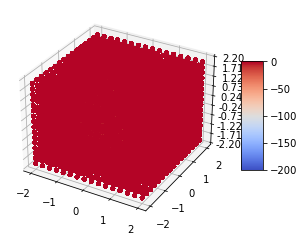

In [22]:
tiempoMostrado = 8 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

mostrado = np.where(t_TEST == np.unique(t_test)[19] )

sliced_1 = np.where(y_TEST < 0.1)
sliced_2 = np.where(y_TEST >-0.1)

sliced = np.intersect1d(sliced_1,sliced_2)

indsliced = np.intersect1d(mostrado,sliced)

error = np.abs(u_pred_sciann-u_pred_Num).flatten()[indsliced]
calor = u_pred_sciann.flatten()[indsliced]

X = x_data[:]
Y = y_data[:]
Z = z_data[:]


surf = ax.scatter(X, Y, Z, c=valCentro ,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
# ax.set_zlim(u_pred_sciann.min(), u_pred_sciann.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

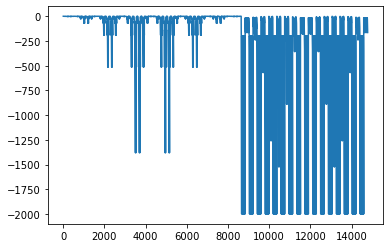

In [423]:
n

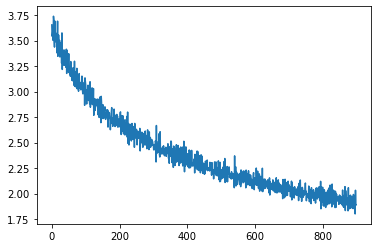

In [24]:
plt.plot(history.history['loss'][100:])

In [52]:
u_pred_sciann =  u.eval(m, [x_test, y_test, z_test, t_test])[:,0]
print(u_pred_sciann.shape)
print(u_pred_Num.shape)

(262000,)
(262000,)


In [23]:
MAE = np.mean(np.abs(u_pred_Num-u_pred_sciann))*640
RMSE = np.sqrt(np.mean((u_pred_Num-u_pred_sciann)**2))*640

pred = m.model.predict([np.reshape(x_test,(-1,)),np.reshape(y_test,(-1,)),np.reshape(z_test,(-1,)),np.reshape(t_test,(-1,))])

funcional =   np.mean(np.abs(np.array(pred[4])))

MAX = np.max(np.abs(u_pred_Num-u_pred_sciann))

print(MAE,RMSE,MAX)

123.04392218165569 149.62428418985272 0.8061192717919923


In [70]:
np.unique(puntos_cart[:,3])

array([0.        , 0.20833333, 0.41666667, 0.625     , 0.83333333,
       1.04166667, 1.25      , 1.45833333, 1.66666667, 1.875     ,
       2.08333333, 2.29166667, 2.5       , 2.70833333, 2.91666667,
       3.125     , 3.33333333, 3.54166667, 3.75      , 3.95833333,
       4.16666667, 4.375     , 4.58333333, 4.79166667, 5.        ])

[Text(-1.0, 0, '−1'),
 Text(0.0, 0, '0'),
 Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5'),
 Text(6.0, 0, '6')]

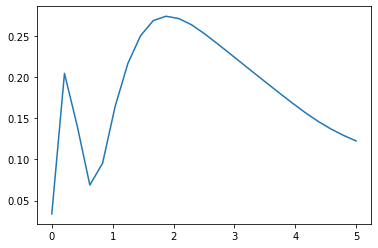

In [72]:
coord = 3

fig = plt.figure()
ax = fig.add_subplot()
ordered_by_time = np.argsort(puntos_cart[:,coord])
slices = np.unique(puntos_cart[ordered_by_time,coord],return_index=True)[1][1:]
resultado = [np.mean(np.abs(array)) for array in np.split(u_pred_sciann[ordered_by_time]-u_pred_Num[ordered_by_time],slices)]
ax.plot(np.unique(puntos_cart[:,3]),resultado)
fig.savefig('timerror.png')
ax.get_xticklabels()

In [42]:
resultado

[nan]

In [73]:
np.unique(t_test)

array([0.        , 0.20833333, 0.41666667, 0.625     , 0.83333333,
       1.04166667, 1.25      , 1.45833333, 1.66666667, 1.875     ,
       2.08333333, 2.29166667, 2.5       , 2.70833333, 2.91666667,
       3.125     , 3.33333333, 3.54166667, 3.75      , 3.95833333,
       4.16666667, 4.375     , 4.58333333, 4.79166667, 5.        ])

In [10]:
x_TEST, y_TEST, z_TEST, t_TEST = x_test.flatten(), y_test.flatten(), z_test.flatten(), t_test.flatten()


In [99]:
np.unique(t_test).shape

(20,)

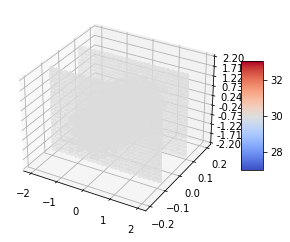

In [13]:
tiempoMostrado = 0 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

mostrado = np.where(t_TEST == np.unique(t_test)[0] )

sliced_1 = np.where(y_TEST < 0.2)
sliced_2 = np.where(y_TEST >-0.2)

sliced = np.intersect1d(sliced_1,sliced_2)

indsliced = np.intersect1d(mostrado,sliced)

calor1 = u_pred_Num.flatten()[indsliced]


X = x_TEST[indsliced]
Y = y_TEST[indsliced]
Z = z_TEST[indsliced]


surf = ax.scatter(X, Y, Z, c=calor1 ,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
# ax.set_zlim(u_pred_sciann.min(), u_pred_sciann.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [34]:
puntos_test.shape

(544680, 4)

In [84]:
xx = np.linspace(xmin, xmax, np.rint(xrange*4*denspt).astype(int) )
yy = np.array([0])
zz = np.linspace(zmin, zmax, np.rint(zrange*4*denspt).astype(int))
tt = np.array([1])

grid = np.meshgrid(xx,yy,zz,tt)

xx_cart, yy_cart, zz_cart, tt_cart = [ coord.flatten() for coord in grid]

puntos_cart = np.stack((xx_cart,yy_cart,zz_cart,tt_cart),axis=1)

#Uno ambas grids

puntos_test = puntos_cart

#Archivos de datos
u_file = 'u.txt'
mesh_file = 'cubo.mesh'
#Predicciones del numérico
puntos, valores = preparadatos(u_file,mesh_file)
print('Datos preparados')
u_pred_Num = griddata(puntos, valores, puntos_test , method='nearest')

Datos preparados


In [85]:
np.sqrt(u_pred_Num.shape[0])

80.0

In [86]:
xx_2 = np.reshape(xx_cart,(80,80))
yy_2 = np.reshape(zz_cart,(80,80))

u_pred_Num_2 = np.reshape(u_pred_Num,(80,80))

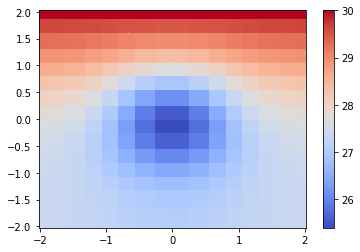

In [87]:
plt.pcolor(xx_2,yy_2,u_pred_Num_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Inicial_Num.png')

In [88]:
u_pred_sn = u.eval(m,[xx_cart, yy_cart, zz_cart, tt_cart])

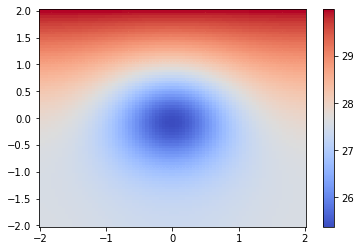

In [89]:
xx_2 = np.reshape(xx_cart,(80,80))
yy_2 = np.reshape(zz_cart,(80,80))

u_pred_sn_2 = np.reshape(u_pred_sn,(80,80))

plt.pcolor(xx_2,yy_2,u_pred_sn_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Inicial_SN.png')

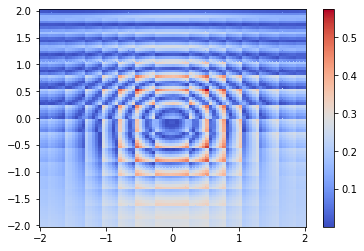

In [90]:
xx_2 = np.reshape(xx_cart,(80,80))
yy_2 = np.reshape(zz_cart,(80,80))

err_2 = np.reshape(np.abs(u_pred_sn-u_pred_Num),(80,80))

plt.pcolor(xx_2,yy_2,err_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Inicial_SN.png')

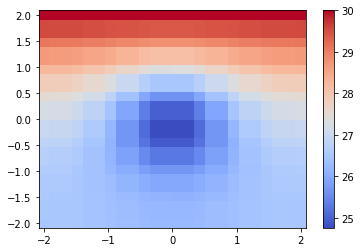

In [107]:
plt.pcolor(xx_2,yy_2,u_pred_Num_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Etapa5.png')

In [90]:
indsliced

array([163879, 163959, 164039, 164119, 164199, 164279, 164359, 164439,
       164519, 164599, 164679, 164759, 164839, 164919, 164999, 165079,
       165159, 165239, 165319, 165399, 165479, 165559, 165639, 165719,
       165799, 165879, 165959, 166039, 166119, 166199, 166279, 166359,
       166439, 166519, 166599, 166679, 166759, 166839, 166919, 166999,
       167079, 167159, 167239, 167319, 167399, 167479, 167559, 167639,
       167719, 167799, 167879, 167959, 168039, 168119, 168199, 168279,
       168359, 168439, 168519, 168599, 168679, 168759, 168839, 168919,
       168999, 169079, 169159, 169239, 169319, 169399, 169479, 169559,
       169639, 169719, 169799, 169879, 169959, 170039, 170119, 170199,
       170279, 170359, 170439, 170519, 170599, 170679, 170759, 170839,
       170919, 170999, 171079, 171159, 171239, 171319, 171399, 171479,
       171559, 171639, 171719, 171799, 171879, 171959, 172039, 172119,
       172199, 172279, 172359, 172439, 172519, 172599, 172679, 172759,
      